In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
                             precision_recall_curve, confusion_matrix, average_precision_score)
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\LAPEI-CIGETS\GitHub\tcp\01_dados\data_mobilidade_v4.csv")

list(df)

['Unnamed: 0',
 'id',
 'id_seq',
 'transicao',
 'V1023',
 'idade',
 'genero',
 'VD3004',
 'V2010',
 'V2005',
 'UF',
 'qtd_pessoas',
 'periodo_ajust',
 'ensino_medio',
 'ensino_superior',
 'raça',
 'posicao_familiar',
 'tempo_desemprego',
 'filhos',
 'regiao',
 'renda_domiciliar',
 'renda_depois']

In [3]:
df_tratado = df.rename(columns={'V1023':'regiao_urbana','VD3004':'escolaridade','V2010':'cor','UF':'uf'})

df_tratado = df_tratado[['transicao','idade','escolaridade', 'genero', 'cor','qtd_pessoas',
                         'periodo_ajust','filhos', 'tempo_desemprego', 'uf',
                        'posicao_familiar', 'renda_domiciliar', 'regiao_urbana']]

bins = [0, 3, 5, 9, 21, float('inf')]
labels = ['Tempo de desemprego: muito baixo', 'Tempo de desemprego: baixo', 
          'Tempo de desemprego: mediano', 'Tempo de desemprego: alto', 'Tempo de desemprego: muito alto']
df_tratado['intervalo_desemprego'] = pd.cut(df_tratado['tempo_desemprego'], bins=bins, labels=labels, right=False)

df_tratado['transicao'] = df_tratado['transicao'].map({'Migrou para TCP': 1, 'Migrou para o setor privado': 0})

df_final = df_tratado.drop(columns = 'tempo_desemprego')

df_final.head(30).style

,transicao,idade,escolaridade,genero,cor,qtd_pessoas,periodo_ajust,filhos,uf,posicao_familiar,renda_domiciliar,regiao_urbana,intervalo_desemprego
0,1,28,Superior completo,Homem,Parda,3.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,750.000000,Capital,Tempo de desemprego: mediano
1,1,33,Médio completo ou equivalente,Homem,Parda,4.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,162.500000,Capital,Tempo de desemprego: muito alto
2,1,24,Médio incompleto ou equivalente,Mulher,Parda,2.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,488.500000,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",Tempo de desemprego: muito alto
3,0,39,Superior completo,Homem,Parda,4.000000,Pré-pandemia,1,Rondônia,Responsável pelo domicílio,378.750000,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",Tempo de desemprego: baixo
4,0,26,Superior completo,Mulher,Parda,3.000000,Pré-pandemia,0,Acre,Não responsável pelo domicílio,418.000000,Capital,Tempo de desemprego: baixo
5,0,49,Fundamental incompleto ou equivalente,Mulher,Parda,3.000000,Pré-pandemia,0,Acre,Responsável pelo domicílio,53.333333,Capital,Tempo de desemprego: mediano
6,0,34,Fundamental completo ou equivalente,Homem,Parda,1.000000,Pré-pandemia,0,Acre,Responsável pelo domicílio,0.000000,Capital,Tempo de desemprego: muito baixo
7,0,42,Sem instrução e menos de 1 ano de estudo,Homem,Branca,3.000000,Pré-pandemia,1,Acre,Não responsável pelo domicílio,318.000000,Capital,Tempo de desemprego: alto
8,0,22,Médio completo ou equivalente,Homem,Parda,6.800000,Pré-pandemia,0,Amazonas,Não responsável pelo domicílio,25.714286,Capital,Tempo de desemprego: alto
9,0,48,Médio completo ou equivalente,Homem,Parda,8.800000,Pré-pandemia,0,Amazonas,Responsável pelo domicílio,408.555556,Capital,Tempo de desemprego: mediano


In [8]:
def dividir(df):
    y = df[['transicao']]
    X = df.drop(columns=['transicao'])

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=22)

    # Aplicar pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicar balanceamento com SMOTE
    smote = SMOTE(random_state=5222)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

    return X_train_balanced, X_test_processed, y_train_balanced, y_test, preprocessor, X_train

In [9]:
x_train, x_test, y_train, y_test, preprocessor, x_train_raw1 = dividir(df_final)

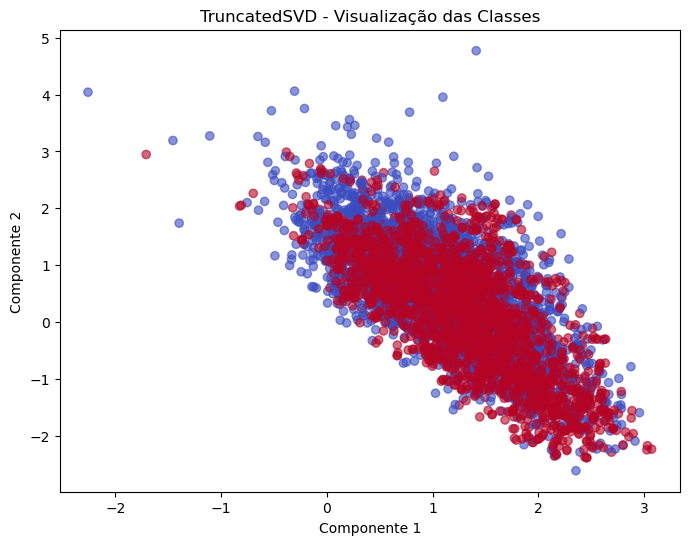

In [10]:
y_train_teste = y_train['transicao'].values
svd = TruncatedSVD(n_components=2, random_state=42)
x_svd = svd.fit_transform(x_train)

plt.figure(figsize=(8,6))
plt.scatter(x_svd[:,0], x_svd[:,1], c=y_train_teste, cmap='coolwarm', alpha=0.6)
plt.title('TruncatedSVD - Visualização das Classes')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

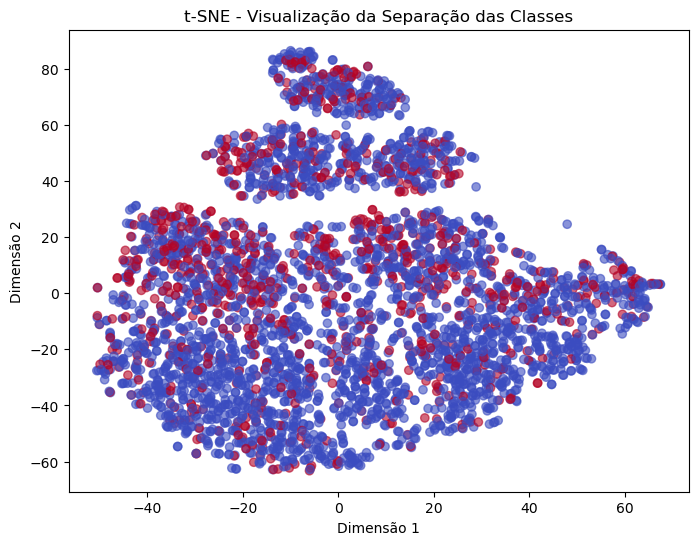

In [7]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='random')
X_tsne = tsne.fit_transform(x_train)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train_teste, cmap='coolwarm', alpha=0.6)
plt.title('t-SNE - Visualização da Separação das Classes')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.show()

In [6]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# --- Função Objetivo para o Optuna (ATUALIZADA PARA PR AUC) ---
def objective(trial, model_name, x_train, y_train):
    """
    Função objetivo que o Optuna tentará maximizar.
    Usa validação cruzada para avaliar o desempenho de uma dada combinação de hiperparâmetros.
    """
    # A definição dos hiperparâmetros permanece a mesma
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('C', 1e-2, 10, log=True)
        model = LogisticRegression(C=C, random_state=42, solver='liblinear')

    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        gamma = trial.suggest_float('gamma', 0, 1.0)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss', random_state=42)

    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        num_leaves = trial.suggest_int('num_leaves', 20, 100)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, random_state=42)

    # Para garantir a reprodutibilidade da validação cruzada
    cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # **MUDANÇA PRINCIPAL AQUI**
    # A métrica agora é 'average_precision', que corresponde à área sob a curva Precision-Recall.
    score = cross_val_score(model, x_train, y_train, cv=cv_splitter, scoring='average_precision', n_jobs=-1) # <-- MUDANÇA AQUI

    # Retorna a média das pontuações dos folds
    return score.mean()

# --- Função Principal de Treinamento e Avaliação (ATUALIZADA) ---
def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    """
    Orquestra a otimização com Optuna e a avaliação final.
    """
    best_models = {}

    for name in models.keys():
        print(f"Otimizando o modelo: {name}")
        func = lambda trial: objective(trial, name, x_train, y_train)
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(func, n_trials=20)
        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

        best_model_class = models[name].__class__
        best_params = study.best_params
        
        # Ajustes especiais para modelos que não aceitam todos os parâmetros no construtor
        if name == 'Logistic Regression':
            best_params['solver'] = 'liblinear'
        
        best_model = best_model_class(**best_params, random_state=42)
        
        if name in ['XGBoost']:
            best_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        
        best_model.fit(x_train, y_train)
        best_models[name] = best_model

    # Avaliação no conjunto de teste (RELATÓRIO ATUALIZADO)
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob),
            'PR AUC': average_precision_score(y_test, y_prob) # <-- MÉTRICA ADICIONADA AO RELATÓRIO
        })

    # Converte para DataFrame para melhor visualização
    return results, best_models

In [26]:
results_df, final_models = treinando_avaliando_optuna(x_train, y_train, x_test, y_test)
results_m1_df = pd.DataFrame(results_df)
print(results_m1_df.sort_values(by = 'ROC AUC', ascending = False))

[I 2025-06-18 17:30:19,318] A new study created in memory with name: no-name-335f4e00-3388-42e2-a516-e0b4c2bb9d2d


Otimizando o modelo: Logistic Regression


[I 2025-06-18 17:30:20,988] Trial 0 finished with value: 0.6925280556163528 and parameters: {'C': 0.13292918943162169}. Best is trial 0 with value: 0.6925280556163528.
[I 2025-06-18 17:30:22,160] Trial 1 finished with value: 0.6973565737794676 and parameters: {'C': 7.114476009343421}. Best is trial 1 with value: 0.6973565737794676.
[I 2025-06-18 17:30:23,108] Trial 2 finished with value: 0.6952441586047104 and parameters: {'C': 1.5702970884055387}. Best is trial 1 with value: 0.6973565737794676.
[I 2025-06-18 17:30:23,156] Trial 3 finished with value: 0.6934512940827154 and parameters: {'C': 0.6251373574521749}. Best is trial 1 with value: 0.6973565737794676.
[I 2025-06-18 17:30:23,208] Trial 4 finished with value: 0.6919185449228531 and parameters: {'C': 0.02938027938703535}. Best is trial 1 with value: 0.6973565737794676.
[I 2025-06-18 17:30:23,261] Trial 5 finished with value: 0.6919168843740282 and parameters: {'C': 0.029375384576328288}. Best is trial 1 with value: 0.6973565737794

Melhores parâmetros para Logistic Regression: {'C': 9.844498380225959}

Otimizando o modelo: Decision Tree


[I 2025-06-18 17:30:24,622] Trial 1 finished with value: 0.806228227557973 and parameters: {'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.806228227557973.
[I 2025-06-18 17:30:24,722] Trial 2 finished with value: 0.6500578809389879 and parameters: {'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.806228227557973.
[I 2025-06-18 17:30:24,837] Trial 3 finished with value: 0.8348336186593521 and parameters: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.8348336186593521.
[I 2025-06-18 17:30:24,922] Trial 4 finished with value: 0.793578015997633 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8348336186593521.
[I 2025-06-18 17:30:24,973] Trial 5 finished with value: 0.7361331750579286 and parameters: {'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 3 with v

Melhores parâmetros para Decision Tree: {'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 10}

Otimizando o modelo: Random Forest


[I 2025-06-18 17:30:32,506] Trial 0 finished with value: 0.9278374961014283 and parameters: {'n_estimators': 400, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9278374961014283.
[I 2025-06-18 17:30:33,551] Trial 1 finished with value: 0.8746703744813754 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9278374961014283.
[I 2025-06-18 17:30:41,700] Trial 2 finished with value: 0.9180392870871641 and parameters: {'n_estimators': 700, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9278374961014283.
[I 2025-06-18 17:30:47,008] Trial 3 finished with value: 0.8945528894307507 and parameters: {'n_estimators': 900, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9278374961014283.
[I 2025-06-18 17:30:51,589] Trial 4 finished with value: 0.9219882084526816 and parameters: {'

Melhores parâmetros para Random Forest: {'n_estimators': 200, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 1}



[I 2025-06-18 17:31:51,433] A new study created in memory with name: no-name-fa10f5e4-250b-491e-acf0-d39c80c610d2


Otimizando o modelo: XGBoost


[I 2025-06-18 17:31:53,871] Trial 0 finished with value: 0.9162714057768394 and parameters: {'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'gamma': 0.15599452033620265}. Best is trial 0 with value: 0.9162714057768394.
[I 2025-06-18 17:31:54,415] Trial 1 finished with value: 0.9230170725009611 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.9699098521619943}. Best is trial 1 with value: 0.9230170725009611.
[I 2025-06-18 17:31:56,352] Trial 2 finished with value: 0.9238169394576834 and parameters: {'n_estimators': 900, 'max_depth': 4, 'learning_rate': 0.01855998084649059, 'subsample': 0.6733618039413735, 'colsample_bytree': 0.7216968971838151, 'gamma': 0.5247564316322378}. Best is trial 2 with value: 0.9238169394576834.
[I 2025-06-18 17:31:57,829] Trial 3 finished

Melhores parâmetros para XGBoost: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.01351182947645082, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'gamma': 0.32533033076326434}



[I 2025-06-18 17:32:58,320] A new study created in memory with name: no-name-aec2b910-85a4-473f-b423-5511f01faf3d


Otimizando o modelo: LightGBM


[I 2025-06-18 17:33:04,380] Trial 0 finished with value: 0.9174545993749017 and parameters: {'n_estimators': 400, 'learning_rate': 0.2536999076681772, 'num_leaves': 79, 'min_child_samples': 32}. Best is trial 0 with value: 0.9174545993749017.
[I 2025-06-18 17:33:06,932] Trial 1 finished with value: 0.9184237602265523 and parameters: {'n_estimators': 200, 'learning_rate': 0.01699897838270077, 'num_leaves': 24, 'min_child_samples': 44}. Best is trial 1 with value: 0.9184237602265523.
[I 2025-06-18 17:33:10,712] Trial 2 finished with value: 0.9160840804871011 and parameters: {'n_estimators': 700, 'learning_rate': 0.11114989443094977, 'num_leaves': 21, 'min_child_samples': 49}. Best is trial 1 with value: 0.9184237602265523.
[I 2025-06-18 17:33:16,216] Trial 3 finished with value: 0.9231685617502151 and parameters: {'n_estimators': 900, 'learning_rate': 0.020589728197687916, 'num_leaves': 34, 'min_child_samples': 13}. Best is trial 3 with value: 0.9231685617502151.
[I 2025-06-18 17:33:19,3

Melhores parâmetros para LightGBM: {'n_estimators': 400, 'learning_rate': 0.013940346079873234, 'num_leaves': 75, 'min_child_samples': 25}

[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
3              XGBoost  0.767516   0.621212  0.174468  0.272425  0.709820   
0  Logistic Regression  0.657113   0.384211  0.621277  0.474797  0.700370   
2        Random Forest  0.749469   0.496350  0.289362  0.365591  0.693039   
4             LightGBM  0.743100   0.469565  0.22978

In [27]:
#Identificando o nome do algoritmo com a melhor ROC AUC
best_model_name = results_m1_df.sort_values(by='PR AUC', ascending=False).iloc[0]['Model']

#Recuperando o algoritmo com base no nome do algoritmo
best_model_m1 = final_models[best_model_name]

C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [17:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhor limiar: 0.34765276312828064 com F1 Score: 0.8989705112545804


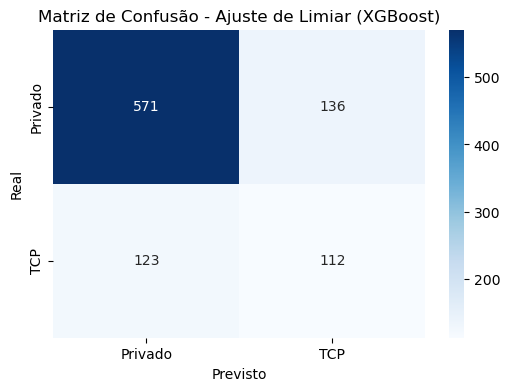

In [28]:
# Treine o modelo
best_model_m1.fit(x_train, y_train)

# Calcular probabilidades e encontrar o melhor limiar baseado no F1 Score
y_prob_train = best_model_m1.predict_proba(x_train)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_train)

best_threshold, best_f1 = max(((threshold, f1_score(y_train, (y_prob_train >= threshold).astype(int))) for threshold in thresholds), key=lambda x: x[1])

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Ajustar previsões no conjunto de teste
y_pred_adjusted = (best_model_m1.predict_proba(X=x_test)[:, 1] >= best_threshold).astype(int)

# Matriz de Confusão
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Exibição da Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Privado', 'TCP'], yticklabels=['Privado', 'TCP'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [29]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred_adjusted))
print('PR AUC', average_precision_score(y_test, y_pred_adjusted))

ROC AUC:  0.6421168256643294
Precision:  0.45161290322580644
Accuracy:  0.7250530785562632
Recall:  0.4765957446808511
F1 Score:  0.463768115942029
PR AUC 0.34581003632802765


In [30]:
# CORREÇÃO: Use o TreeExplainer e passe o objeto do modelo diretamente
explainer = shap.TreeExplainer(best_model_m1) 

# O cálculo dos valores SHAP agora funciona corretamente
shap_values = explainer.shap_values(x_test)

# Para visualizar a primeira predição
shap.initjs()

C:\Users\alefs\anaconda3\lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


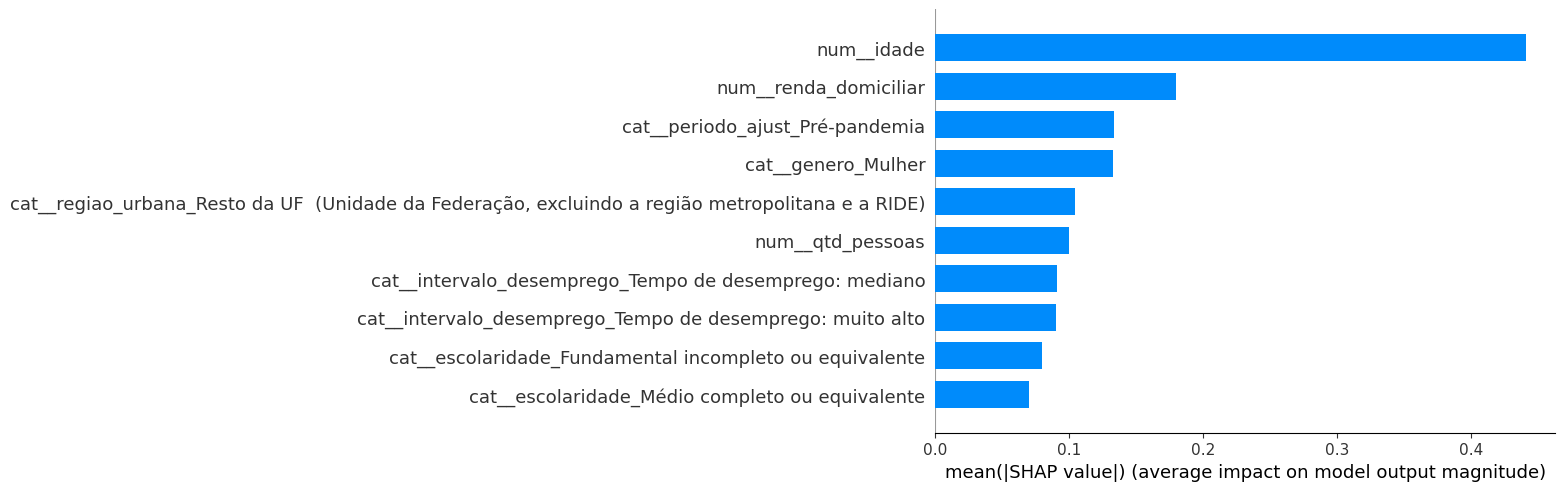

In [31]:
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, features= x_test,
                  feature_names= feature_names,
                  plot_type="bar",
                 max_display = 10)

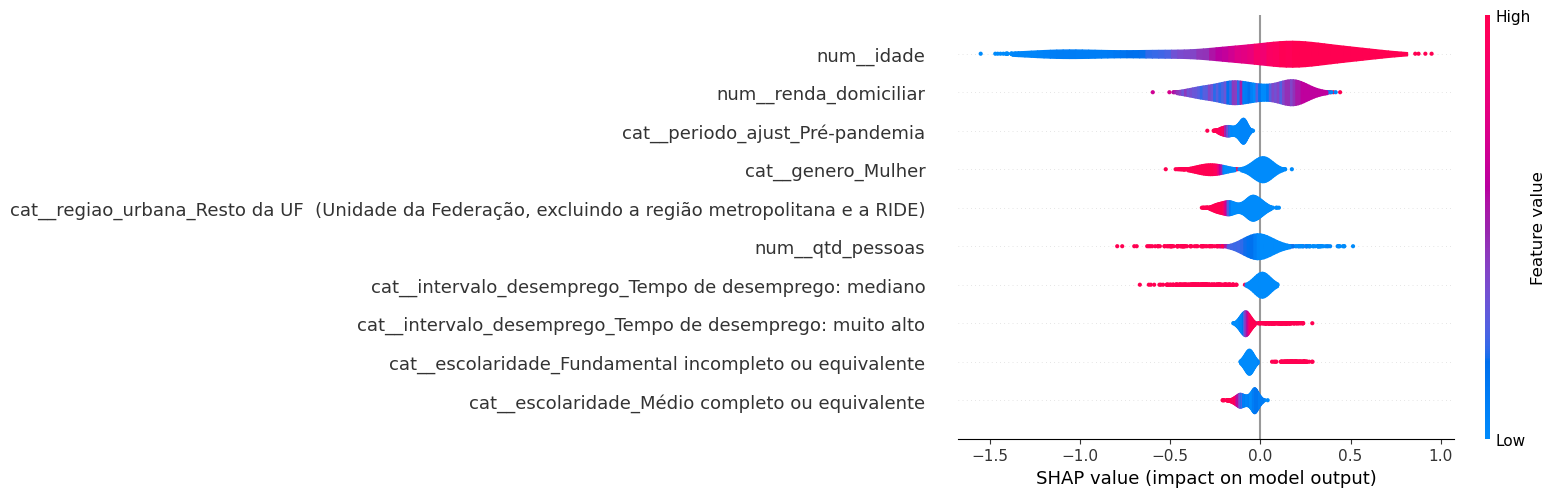

In [32]:
shap.summary_plot(shap_values, 
                  features=x_test.toarray(), # <--- A MUDANÇA PRINCIPAL ESTÁ AQUI
                  feature_names=feature_names,
                  plot_type="violin",
                  max_display=10)